### 環境設置與導入需要的套件

In [1]:
# 環境設置
import os
import re
import torch
import warnings
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
torch.backends.cudnn.benchmark=True
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import cv2
from skimage import io
from PIL import Image
import torchvision
from torch import nn
from torch import optim
import torchvision.utils as vutils
from torchvision import transforms
from torchvision import models as M
from torchvision import datasets as dest
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchinfo import summary

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd
import datetime
from time import time
import gc

from sklearn.model_selection import train_test_split

manualSeed=1412
torch.manual_seed(manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1060 6GB (UUID: GPU-25c2fd70-a007-9642-1310-c8fa56a6eb17)


### 建立cGAN判別器與生成器模型

In [4]:
# 判別器
class cGAN_disc(nn.Module):
    def __init__(self):
        super().__init__()
        #轉化標籤, MNIST有10個class, 用Embedding升至50個特徵, 再用線性層升至784個特徵
        self.label_embedding = nn.Sequential(nn.Embedding(10,50)
                                             ,nn.Linear(50,784)
                                             ,nn.ReLU(True)
                                            )
        #核心結構
        self.main = nn.Sequential(nn.Conv2d(2,128,kernel_size=3,stride=2,padding=1)
                                 ,nn.LeakyReLU(0.2,inplace=True)
                                 ,nn.Conv2d(128,128,3,2,1)
                                 ,nn.LeakyReLU(0.2,inplace=True)
                                 )
        #輸出
        self.output = nn.Sequential(nn.Dropout(0.2)
                                ,nn.Linear(128*7*7,1)
                                ,nn.Sigmoid()
                                )
        
    def forward(self,label,realdata):
        #處理標籤
        label = self.label_embedding(label)
        label = label.view(-1,1,28,28)
        
        #合併標籤與數據
        inputs = torch.cat((realdata,label),dim=1)
        
        #將合併數據輸入核心架構
        features = self.main(inputs)
        
        #將features拉平，輸入最後的線性層
        features = features.view(-1,7*7*128)
        outputs = self.output(features)
        return outputs

In [5]:
# 生成器
class cGAN_gen(nn.Module):
    def __init__(self):
        super().__init__()
        # 標籤的上採樣
        self.label_upsample = nn.Sequential(nn.Embedding(10, 50), 
                                            nn.Linear(50, 49), 
                                            nn.ReLU(True))
        # 噪音的上採樣
        self.noise_upsample = nn.Sequential(nn.Linear(100, 6272), 
                                            nn.LeakyReLU(0.2, True))
        
        # 核心架構
        self.main = nn.Sequential(nn.ConvTranspose2d(129, 128, kernel_size=4, stride=2, padding=1), 
                                  nn.LeakyReLU(0.2, True), 
                                  nn.ConvTranspose2d(128, 128, 4, 2, 1), 
                                  nn.LeakyReLU(0.2, True), 
                                  nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1))
        
                                  
    def forward(self, label, noise):
        # 轉化標籤
        label = self.label_upsample(label)
        label = label.view(-1, 1, 7, 7)
        
        # 轉化噪音
        noise = self.noise_upsample(noise)
        noise = noise.view(-1, 128, 7, 7)
                                  
        # 合併數據
        inputs = torch.cat((label, noise), dim=1)
        
        # 將數據輸入核心架構, 生成假數據
        fakedata = self.main(inputs)  # (-1, 1, 28, 28)
        return fakedata

### 導入數據與設置超參數, 實例化模型及定義損失函數與優化器

In [6]:
"""

在執行任意神經網絡的反向傳播之前，我們必須先定義好以下最為核心的元素：

1）數據 - 通常先導入為Datasets，再分批次變為dataloader
2）神經網路 - 對生成對抗網路來說就是生成器和判別器
3）損失函數
4）優化器
5）各類超參數和硬件設置，包括epochs的數量，學習率、gpu設備等等

"""

batch_size = 32
lr = 3e-4  # 0.0003
num_epochs = 50
realdata_dim = 28*28*1  # 784
z_dim = 100
noise = torch.ones((10,100))

# 設備設置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 真實數據 - 以最為簡單的MNIST數據為例
transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Normalize((0.5),(0.5))])  # 歸一化到-1~1之間

dataset = dest.MNIST(root=r"D:\TGI102_AI_BootCamp\Pytorch\datasets\L18\MNIST",transform=transform,download=False)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

# 設置一組固定的噪音數據，用於在訓練中不斷驗證生成器的結果
# 作為需要輸入生成器的噪音，這組數據的樣本量應與batch_size一致，維度可自由選擇
# 注意區別於訓練中不斷放入G的噪音z
fixed_noise = torch.randn((batch_size,z_dim)).to(device)

# 實例化判別器與生成器
gen = cGAN_gen().to(device)
disc = cGAN_disc().to(device)

# 定義判別器與生成器所使用的優化算法
optim_disc = optim.Adam(disc.parameters(),lr=lr,betas=(0.9,0.999))
optim_gen = optim.Adam(gen.parameters(),lr=lr,betas=(0.9,0.999))

# 定義損失函數
criterion = nn.BCELoss(reduction="mean")  # 默認生成均值，也可以特定標明生成均值

In [7]:
len(dataloader)

1875

In [8]:
for x, y in dataloader:
    print(x.shape)
    print(y)
    print(np.unique(y))
    break

torch.Size([32, 1, 28, 28])
tensor([7, 2, 1, 7, 1, 9, 4, 0, 4, 2, 8, 6, 3, 8, 0, 8, 3, 7, 0, 4, 0, 2, 1, 5,
        9, 1, 7, 5, 0, 9, 4, 0])
[0 1 2 3 4 5 6 7 8 9]


In [13]:
net = nn.Sequential(nn.Embedding(10,50)
                       ,nn.Linear(50,784)
                       ,nn.ReLU(True))
# net = net.to(device)
result = net(y)
print(result.shape)
result = result.view(-1, 1, 28, 28)
print(result.shape)
print(x.shape)
print(torch.cat((x, result), dim=1).shape)

torch.Size([32, 784])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 2, 28, 28])


In [11]:
# 在訓練完畢之後，如果需要繼續訓練，則不要運行這一個cell
img_list = []  # 在訓練過程中不斷將fixed_noise輸入生成器，儲存這些不斷生成的假數據的列表
G_losses = []
D_real_loss = []
D_fake_loss = []
D_losses = []
iters = 0

In [15]:
for epoch in range(num_epochs):
    for batch_idx, (x,y) in enumerate(dataloader):

        x = x.to(device)
        batch_size = x.shape[0]
        y = y.to(device)
        
        ############################
        # (1) 判別器的反向傳播：最小化 -[logD(x) + log(1 - D(G(z)))]
        ############################

        # -logdx
        disc_output_real = disc(y, x).view(-1)
        loss_real = criterion(disc_output_real,torch.ones_like(disc_output_real))
        loss_real.backward()
        D_x = disc_output_real.mean().item()

        # -log(1-dgz)
        noise = torch.randn((batch_size,z_dim)).to(device)
        gen_ouput_fakedata = gen(y, noise)
        disc_output_fake = disc(y.detach(), gen_ouput_fakedata.detach())
        loss_fake = criterion(disc_output_fake,torch.zeros_like(disc_output_fake))
        loss_fake.backward()
        D_G_z1 = disc_output_fake.mean().item()

        # 計算errorD
        errorD = (loss_real + loss_fake)/2
        optim_disc.step()
        disc.zero_grad()
    
        ############################
        # (2) 生成器的反向傳播：最小化 -log(D(G(z)))
        ############################
        # 生成需要輸入criterion的真實標籤1與預測概率disc_output_fake
        # 注意，由於在此時判別器上的權重已經被更新過了，所以disc_output_fake的值會變化，需要重新生成
        disc_output_fake2 = disc(y, gen_ouput_fakedata)
        # 計算errorG
        errorG = criterion(disc_output_fake2,torch.ones_like(disc_output_fake2))
        errorG.backward() # 反向傳播
        optim_gen.step() # 更新生成器上的權重
        gen.zero_grad() # 清零生成器更新後梯度
        D_G_z2 = disc_output_fake2.mean().item()
        
        # 監控訓練進度
        if batch_idx % 500 == 0 or batch_idx == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' %
                  (epoch+1, num_epochs, batch_idx, len(dataloader),errorD.item(), errorG.item(), D_x, D_G_z1, D_G_z2))

        # 保存errorG和errorD，以便後續繪圖用
        G_losses.append(errorG.item())
        D_real_loss.append(loss_real.item())
        D_fake_loss.append(loss_fake.item())
        D_losses.append(errorD.item())

        # 將固定噪音fixed_noise輸入生成器，查看輸出的結果變化
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(y, fixed_noise).cpu().detach()
            print("fake data saved")
            img_list.append(fake.view(-1,1,28,28))

        iters += 1

[1/50][0/1875]	Loss_D: 0.6929	Loss_G: 0.6998	D(x): 0.4952	D(G(z)): 0.4947 / 0.4968
fake data saved
[1/50][500/1875]	Loss_D: 0.6265	Loss_G: 0.6795	D(x): 0.7385	D(G(z)): 0.5997 / 0.5186
fake data saved
[1/50][1000/1875]	Loss_D: 0.6473	Loss_G: 0.4619	D(x): 0.8080	D(G(z)): 0.6568 / 0.6316
fake data saved
[1/50][1500/1875]	Loss_D: 0.5321	Loss_G: 0.4969	D(x): 0.8110	D(G(z)): 0.5674 / 0.6120
fake data saved
[2/50][0/1875]	Loss_D: 0.5786	Loss_G: 0.5663	D(x): 0.7963	D(G(z)): 0.5936 / 0.5730
fake data saved
[2/50][500/1875]	Loss_D: 0.4802	Loss_G: 0.6060	D(x): 0.8106	D(G(z)): 0.5096 / 0.5574
fake data saved
[2/50][1000/1875]	Loss_D: 0.5437	Loss_G: 0.5540	D(x): 0.8774	D(G(z)): 0.6056 / 0.5806
fake data saved
[2/50][1500/1875]	Loss_D: 0.5859	Loss_G: 0.5955	D(x): 0.7941	D(G(z)): 0.5876 / 0.5624
fake data saved
[3/50][0/1875]	Loss_D: 0.5333	Loss_G: 0.5175	D(x): 0.8775	D(G(z)): 0.5939 / 0.6048
fake data saved
[3/50][500/1875]	Loss_D: 0.5113	Loss_G: 0.6011	D(x): 0.8497	D(G(z)): 0.5592 / 0.5563
fake dat

[21/50][1000/1875]	Loss_D: 0.5326	Loss_G: 0.5276	D(x): 0.9023	D(G(z)): 0.6007 / 0.6004
fake data saved
[21/50][1500/1875]	Loss_D: 0.4651	Loss_G: 0.6572	D(x): 0.8410	D(G(z)): 0.5160 / 0.5280
fake data saved
[22/50][0/1875]	Loss_D: 0.5291	Loss_G: 0.6697	D(x): 0.8688	D(G(z)): 0.5820 / 0.5256
fake data saved
[22/50][500/1875]	Loss_D: 0.6172	Loss_G: 0.5324	D(x): 0.8855	D(G(z)): 0.6502 / 0.5964
fake data saved
[22/50][1000/1875]	Loss_D: 0.5566	Loss_G: 0.4607	D(x): 0.8542	D(G(z)): 0.5973 / 0.6437
fake data saved
[22/50][1500/1875]	Loss_D: 0.5753	Loss_G: 0.5235	D(x): 0.8942	D(G(z)): 0.6281 / 0.6014
fake data saved
[23/50][0/1875]	Loss_D: 0.5427	Loss_G: 0.6644	D(x): 0.8631	D(G(z)): 0.5903 / 0.5271
fake data saved
[23/50][500/1875]	Loss_D: 0.5180	Loss_G: 0.7750	D(x): 0.8710	D(G(z)): 0.5726 / 0.4754
fake data saved
[23/50][1000/1875]	Loss_D: 0.6152	Loss_G: 0.5709	D(x): 0.8619	D(G(z)): 0.6278 / 0.5791
fake data saved
[23/50][1500/1875]	Loss_D: 0.5099	Loss_G: 0.7383	D(x): 0.8494	D(G(z)): 0.5599 / 0

[42/50][0/1875]	Loss_D: 0.5514	Loss_G: 0.5451	D(x): 0.8568	D(G(z)): 0.5891 / 0.5882
fake data saved
[42/50][500/1875]	Loss_D: 0.5500	Loss_G: 0.6931	D(x): 0.8655	D(G(z)): 0.5929 / 0.5133
fake data saved
[42/50][1000/1875]	Loss_D: 0.4654	Loss_G: 0.6087	D(x): 0.8749	D(G(z)): 0.5374 / 0.5541
fake data saved
[42/50][1500/1875]	Loss_D: 0.5034	Loss_G: 0.7698	D(x): 0.8123	D(G(z)): 0.5187 / 0.4855
fake data saved
[43/50][0/1875]	Loss_D: 0.5179	Loss_G: 0.5241	D(x): 0.8093	D(G(z)): 0.5397 / 0.6038
fake data saved
[43/50][500/1875]	Loss_D: 0.5287	Loss_G: 0.6383	D(x): 0.8574	D(G(z)): 0.5794 / 0.5470
fake data saved
[43/50][1000/1875]	Loss_D: 0.5873	Loss_G: 0.6600	D(x): 0.8673	D(G(z)): 0.6198 / 0.5314
fake data saved
[43/50][1500/1875]	Loss_D: 0.5333	Loss_G: 0.6320	D(x): 0.8622	D(G(z)): 0.5818 / 0.5421
fake data saved
[44/50][0/1875]	Loss_D: 0.5861	Loss_G: 0.4866	D(x): 0.8379	D(G(z)): 0.5925 / 0.6286
fake data saved
[44/50][500/1875]	Loss_D: 0.5257	Loss_G: 0.5794	D(x): 0.8573	D(G(z)): 0.5723 / 0.571

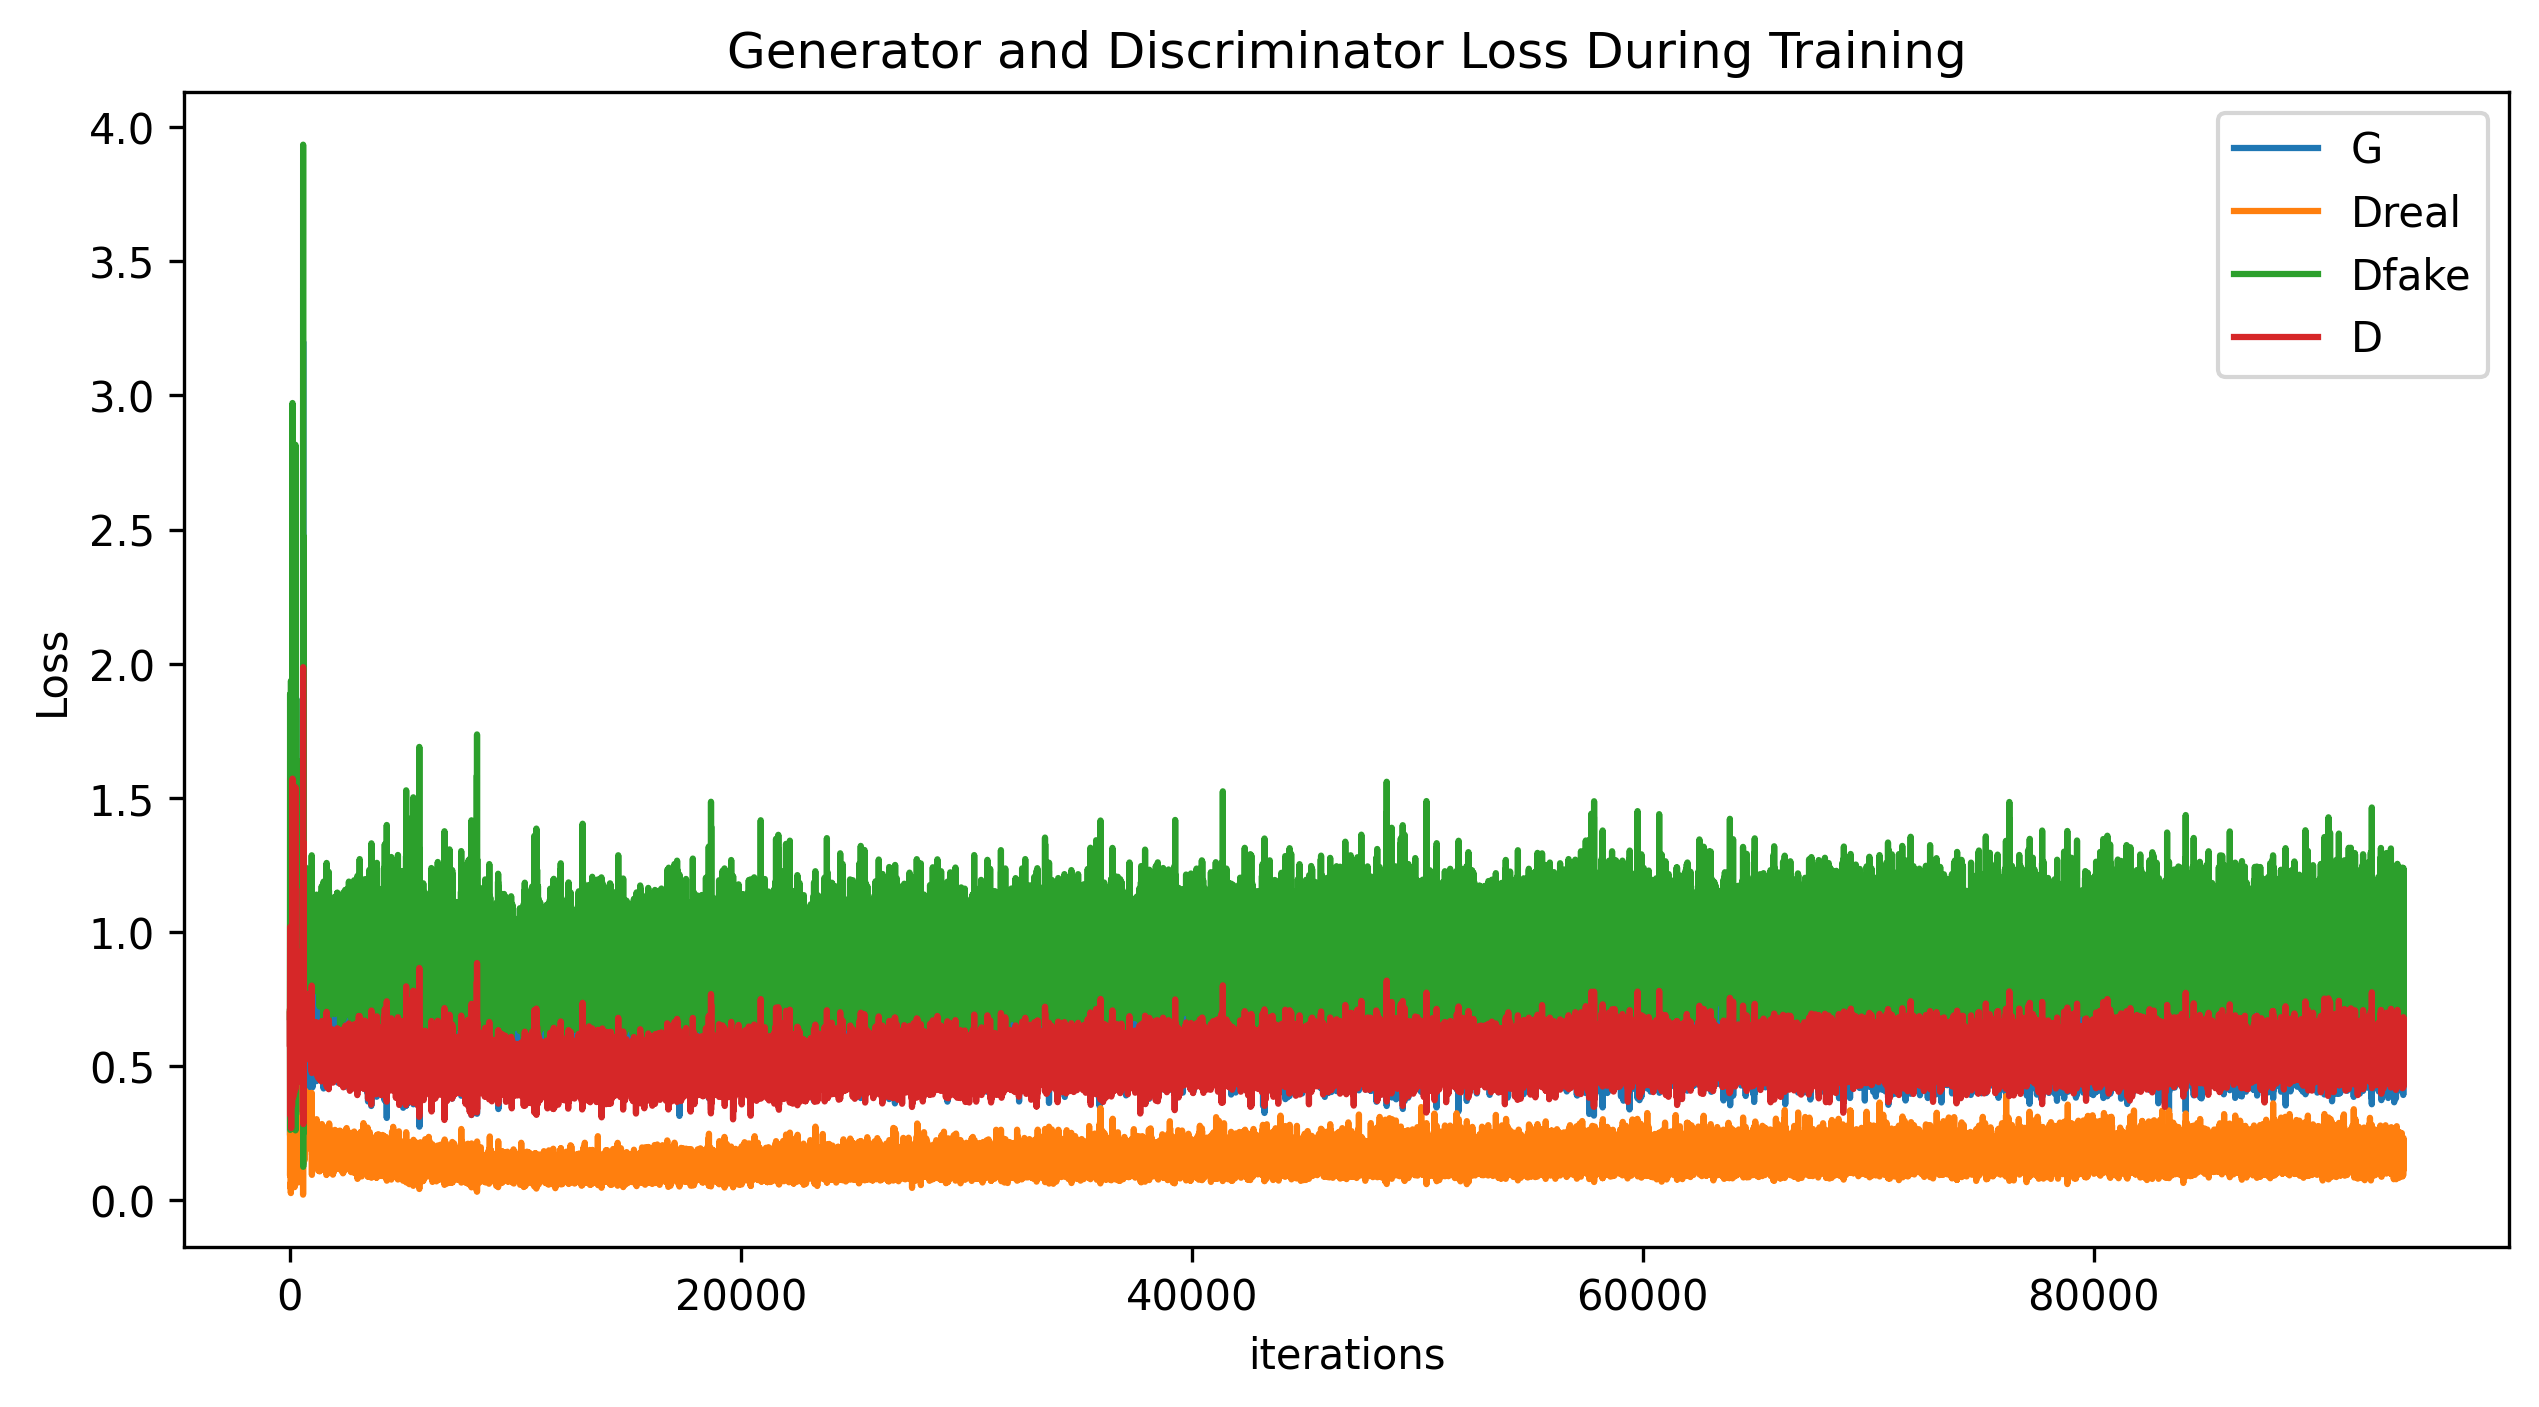

In [16]:
plt.figure(figsize=(10,5),dpi=300)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_real_loss,label="Dreal")
plt.plot(D_fake_loss,label="Dfake")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

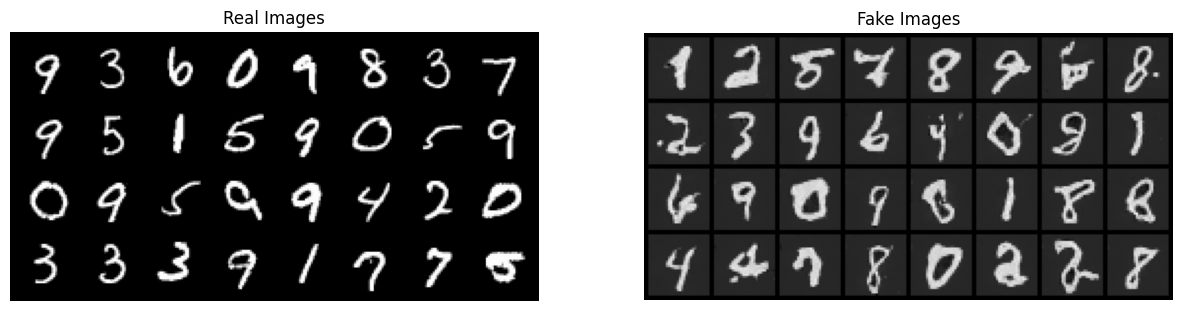

In [17]:
# 繪製原始圖像與生成圖像
real_batch = next(iter(dataloader))

# 原始圖像中抽取一個batch
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=5, normalize=True).cpu(),(1,2,0)))

# 繪製保存的最後一組生成圖像
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1].reshape(-1,1,28,28)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### 再訓練50個Epochs(總共訓練100個Epochs)

In [18]:
for epoch in range(num_epochs):
    for batch_idx, (x,y) in enumerate(dataloader):

        x = x.to(device)
        batch_size = x.shape[0]
        y = y.to(device)
        
        ############################
        # (1) 判別器的反向傳播：最小化 -[logD(x) + log(1 - D(G(z)))]
        ############################

        # -logdx
        disc_output_real = disc(y, x).view(-1)
        loss_real = criterion(disc_output_real,torch.ones_like(disc_output_real))
        loss_real.backward()
        D_x = disc_output_real.mean().item()

        # -log(1-dgz)
        noise = torch.randn((batch_size,z_dim)).to(device)
        gen_ouput_fakedata = gen(y, noise)
        disc_output_fake = disc(y.detach(), gen_ouput_fakedata.detach())
        loss_fake = criterion(disc_output_fake,torch.zeros_like(disc_output_fake))
        loss_fake.backward()
        D_G_z1 = disc_output_fake.mean().item()

        # 計算errorD
        errorD = (loss_real + loss_fake)/2
        optim_disc.step()
        disc.zero_grad()
    
        ############################
        # (2) 生成器的反向傳播：最小化 -log(D(G(z)))
        ############################
        # 生成需要輸入criterion的真實標籤1與預測概率disc_output_fake
        # 注意，由於在此時判別器上的權重已經被更新過了，所以disc_output_fake的值會變化，需要重新生成
        disc_output_fake2 = disc(y, gen_ouput_fakedata)
        # 計算errorG
        errorG = criterion(disc_output_fake2,torch.ones_like(disc_output_fake2))
        errorG.backward() # 反向傳播
        optim_gen.step() # 更新生成器上的權重
        gen.zero_grad() # 清零生成器更新後梯度
        D_G_z2 = disc_output_fake2.mean().item()
        
        # 監控訓練進度
        if batch_idx % 500 == 0 or batch_idx == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' %
                  (epoch+1, num_epochs, batch_idx, len(dataloader),errorD.item(), errorG.item(), D_x, D_G_z1, D_G_z2))

        # 保存errorG和errorD，以便後續繪圖用
        G_losses.append(errorG.item())
        D_real_loss.append(loss_real.item())
        D_fake_loss.append(loss_fake.item())
        D_losses.append(errorD.item())

        # 將固定噪音fixed_noise輸入生成器，查看輸出的結果變化
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(y, fixed_noise).cpu().detach()
            print("fake data saved")
            img_list.append(fake.view(-1,1,28,28))

        iters += 1

[1/50][0/1875]	Loss_D: 0.5527	Loss_G: 0.5652	D(x): 0.9059	D(G(z)): 0.6129 / 0.5822
fake data saved
[1/50][500/1875]	Loss_D: 0.4732	Loss_G: 0.6195	D(x): 0.8591	D(G(z)): 0.5352 / 0.5480
fake data saved
[1/50][1000/1875]	Loss_D: 0.5717	Loss_G: 0.5848	D(x): 0.8630	D(G(z)): 0.6145 / 0.5703
fake data saved
[1/50][1500/1875]	Loss_D: 0.5438	Loss_G: 0.5431	D(x): 0.8197	D(G(z)): 0.5700 / 0.5887
fake data saved
[2/50][0/1875]	Loss_D: 0.6110	Loss_G: 0.5622	D(x): 0.8282	D(G(z)): 0.6266 / 0.5836
fake data saved
[2/50][500/1875]	Loss_D: 0.4642	Loss_G: 0.6006	D(x): 0.8522	D(G(z)): 0.5162 / 0.5656
fake data saved
[2/50][1000/1875]	Loss_D: 0.6673	Loss_G: 0.5396	D(x): 0.8816	D(G(z)): 0.6878 / 0.5932
fake data saved
[2/50][1500/1875]	Loss_D: 0.5443	Loss_G: 0.5126	D(x): 0.8921	D(G(z)): 0.6105 / 0.6083
[3/50][0/1875]	Loss_D: 0.5120	Loss_G: 0.6831	D(x): 0.8501	D(G(z)): 0.5508 / 0.5227
fake data saved
[3/50][500/1875]	Loss_D: 0.6045	Loss_G: 0.5177	D(x): 0.8871	D(G(z)): 0.6386 / 0.6057
fake data saved
[3/50][1

fake data saved
[21/50][1000/1875]	Loss_D: 0.5586	Loss_G: 0.5561	D(x): 0.8915	D(G(z)): 0.6055 / 0.5833
fake data saved
[21/50][1500/1875]	Loss_D: 0.4975	Loss_G: 0.5891	D(x): 0.8435	D(G(z)): 0.5449 / 0.5644
fake data saved
[22/50][0/1875]	Loss_D: 0.6049	Loss_G: 0.6188	D(x): 0.8197	D(G(z)): 0.6109 / 0.5532
fake data saved
[22/50][500/1875]	Loss_D: 0.5598	Loss_G: 0.5989	D(x): 0.8750	D(G(z)): 0.6106 / 0.5582
fake data saved
[22/50][1000/1875]	Loss_D: 0.4950	Loss_G: 0.6355	D(x): 0.8309	D(G(z)): 0.5274 / 0.5438
fake data saved
[22/50][1500/1875]	Loss_D: 0.5503	Loss_G: 0.5700	D(x): 0.8360	D(G(z)): 0.5770 / 0.5757
[23/50][0/1875]	Loss_D: 0.4908	Loss_G: 0.6592	D(x): 0.8490	D(G(z)): 0.5427 / 0.5362
fake data saved
[23/50][500/1875]	Loss_D: 0.5308	Loss_G: 0.6426	D(x): 0.8132	D(G(z)): 0.5516 / 0.5392
fake data saved
[23/50][1000/1875]	Loss_D: 0.5069	Loss_G: 0.6207	D(x): 0.8648	D(G(z)): 0.5569 / 0.5478
fake data saved
[23/50][1500/1875]	Loss_D: 0.4434	Loss_G: 0.6417	D(x): 0.8881	D(G(z)): 0.5182 / 0

[41/50][1500/1875]	Loss_D: 0.5948	Loss_G: 0.5393	D(x): 0.8553	D(G(z)): 0.6195 / 0.5951
fake data saved
[42/50][0/1875]	Loss_D: 0.5547	Loss_G: 0.5136	D(x): 0.8238	D(G(z)): 0.5868 / 0.6089
fake data saved
[42/50][500/1875]	Loss_D: 0.5748	Loss_G: 0.5627	D(x): 0.8591	D(G(z)): 0.6066 / 0.5860
fake data saved
[42/50][1000/1875]	Loss_D: 0.5209	Loss_G: 0.6705	D(x): 0.8339	D(G(z)): 0.5606 / 0.5216
fake data saved
[42/50][1500/1875]	Loss_D: 0.5561	Loss_G: 0.5606	D(x): 0.8219	D(G(z)): 0.5699 / 0.5827
[43/50][0/1875]	Loss_D: 0.5476	Loss_G: 0.5584	D(x): 0.7939	D(G(z)): 0.5536 / 0.5842
fake data saved
[43/50][500/1875]	Loss_D: 0.5021	Loss_G: 0.6101	D(x): 0.8655	D(G(z)): 0.5608 / 0.5603
fake data saved
[43/50][1000/1875]	Loss_D: 0.5789	Loss_G: 0.5067	D(x): 0.8774	D(G(z)): 0.6256 / 0.6121
fake data saved
[43/50][1500/1875]	Loss_D: 0.4565	Loss_G: 0.6915	D(x): 0.8084	D(G(z)): 0.4866 / 0.5149
fake data saved
[44/50][0/1875]	Loss_D: 0.5670	Loss_G: 0.6178	D(x): 0.8420	D(G(z)): 0.5960 / 0.5512
fake data sav

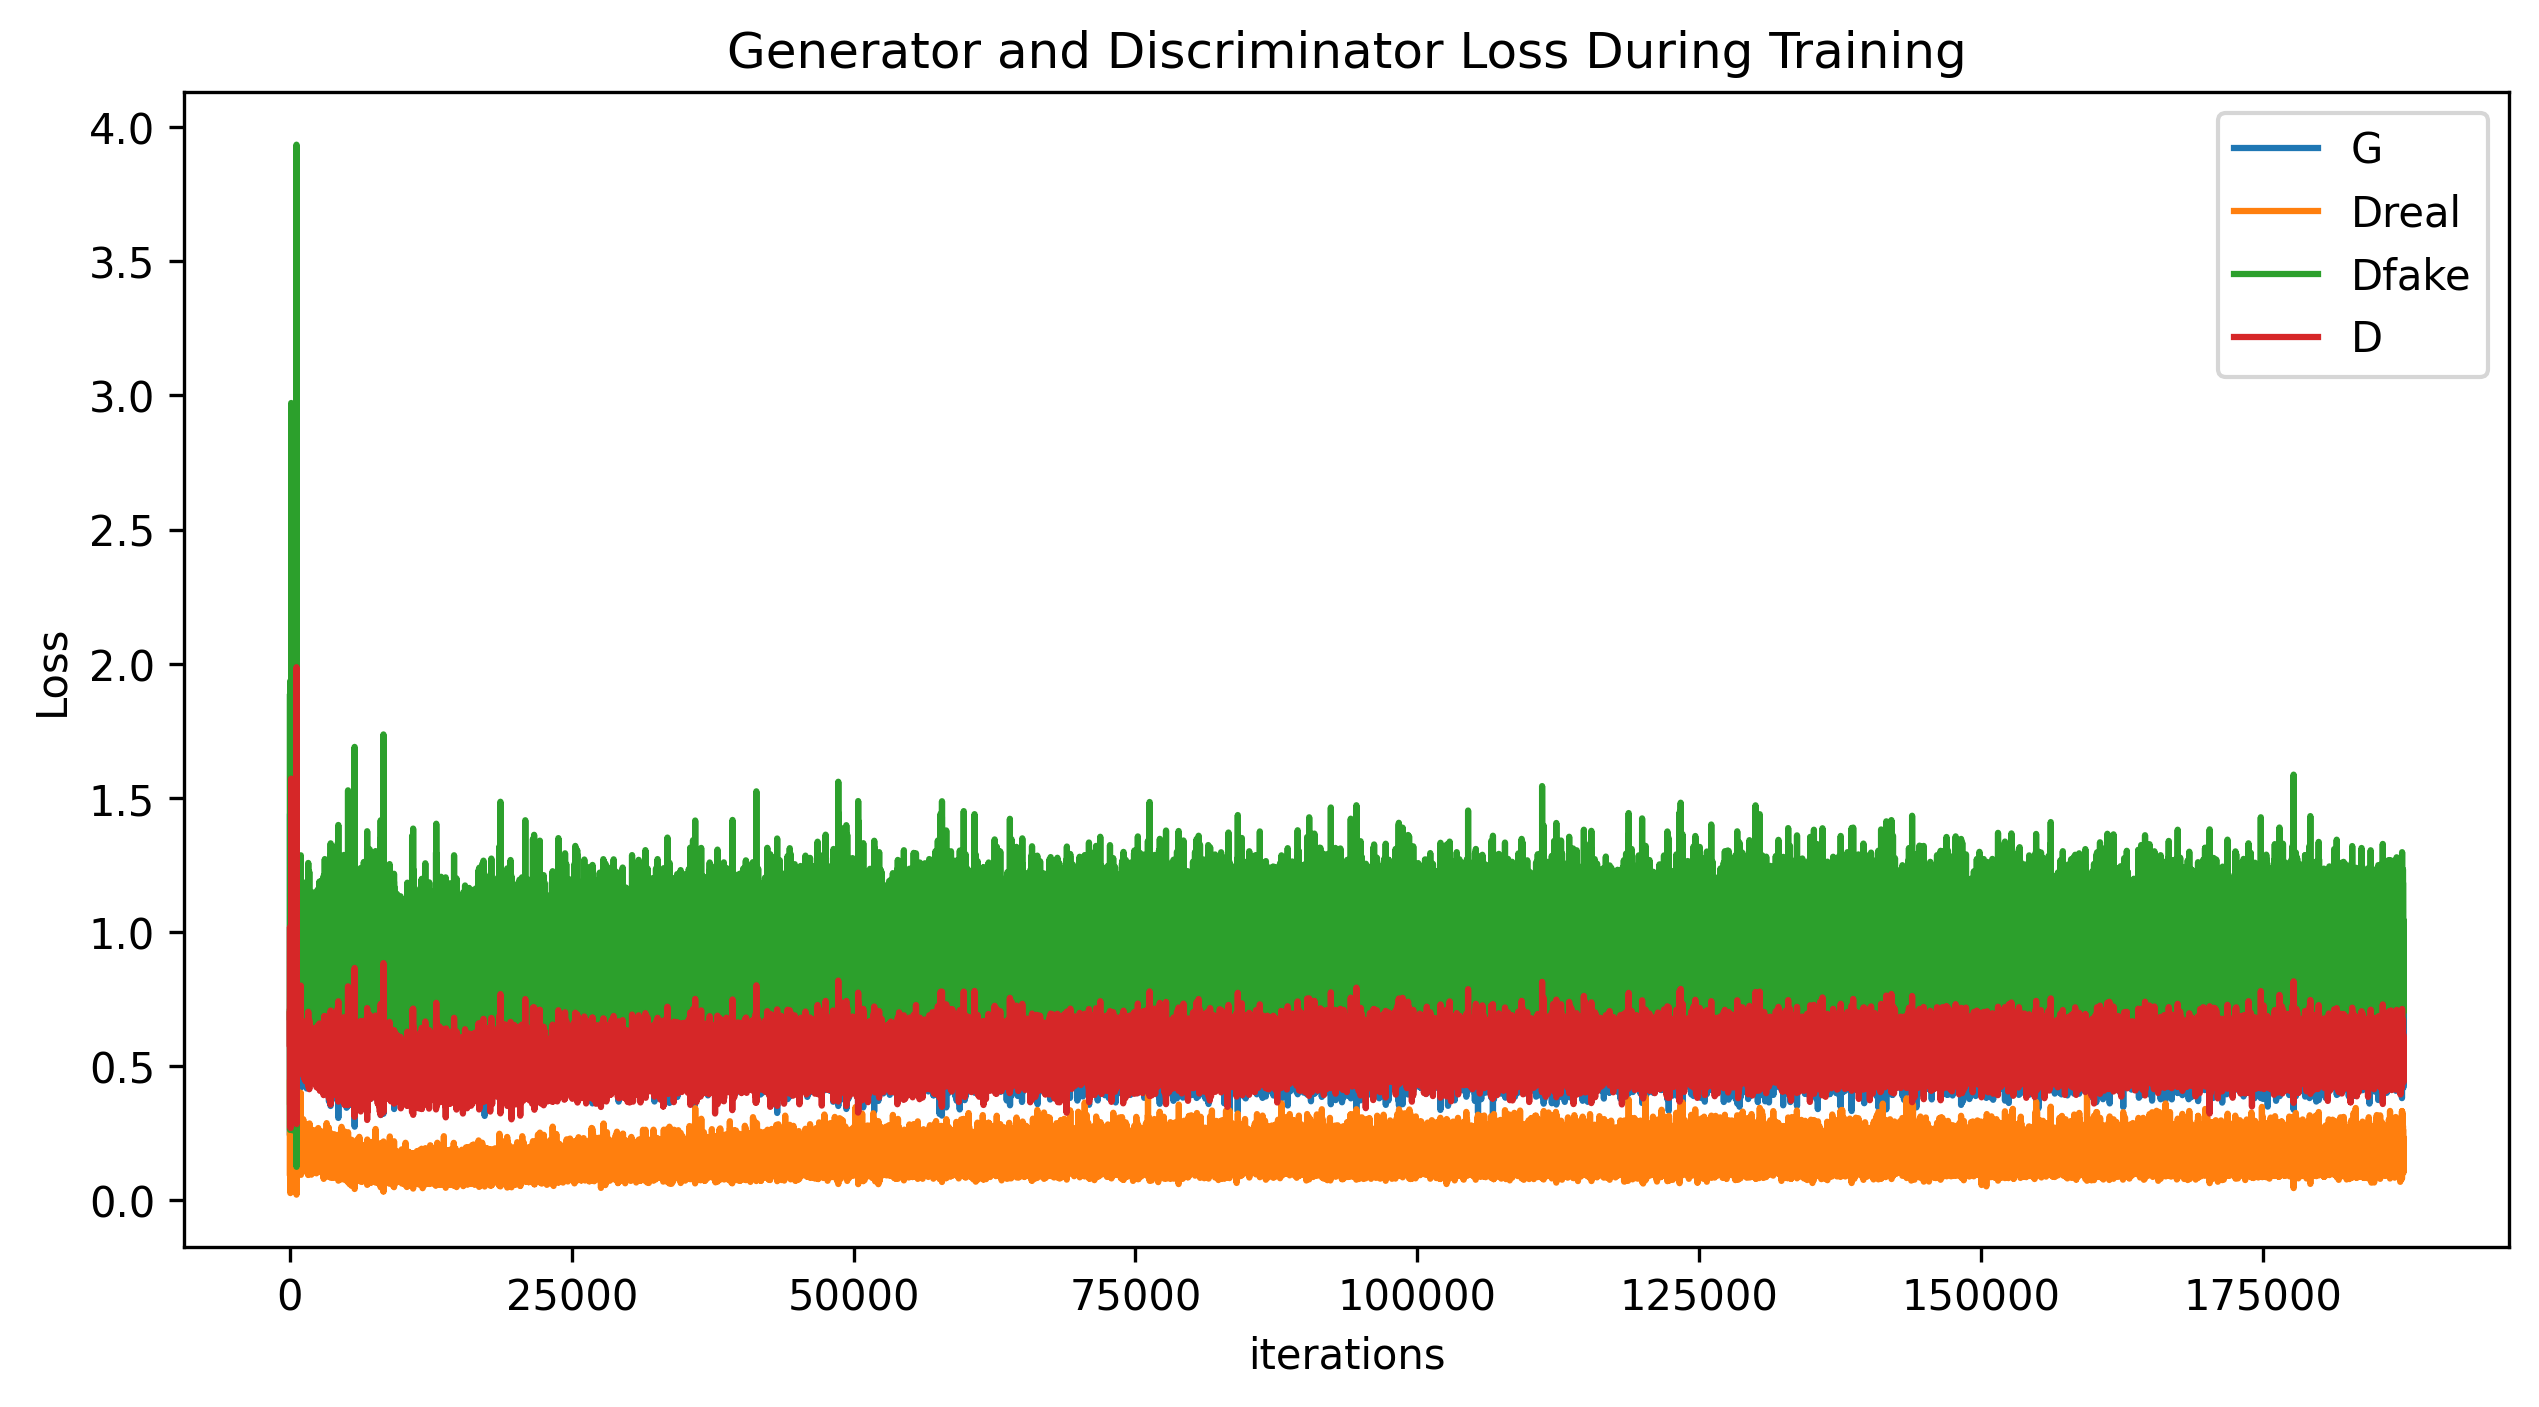

In [19]:
plt.figure(figsize=(10,5),dpi=300)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_real_loss,label="Dreal")
plt.plot(D_fake_loss,label="Dfake")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

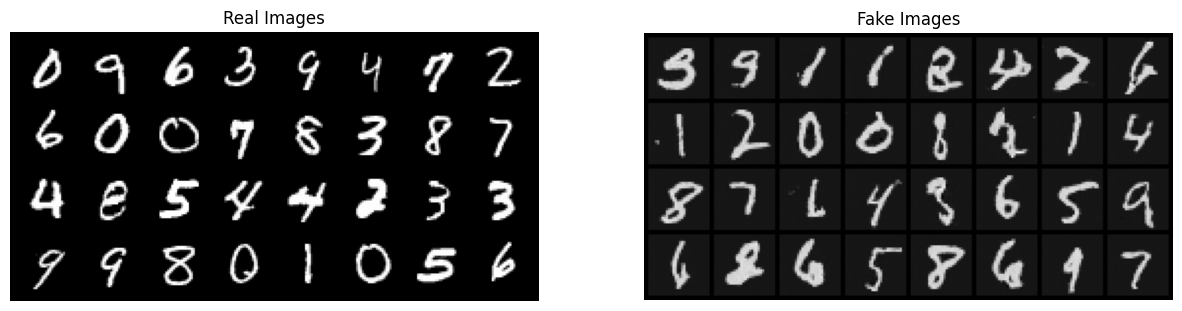

In [20]:
# 繪製原始圖像與生成圖像
real_batch = next(iter(dataloader))

# 原始圖像中抽取一個batch
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=5, normalize=True).cpu(),(1,2,0)))

# 繪製保存的最後一組生成圖像
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1].reshape(-1,1,28,28)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### 再訓練50個Epochs(總共訓練150個Epochs)

In [22]:
for epoch in range(num_epochs):
    for batch_idx, (x,y) in enumerate(dataloader):

        x = x.to(device)
        batch_size = x.shape[0]
        y = y.to(device)
        
        ############################
        # (1) 判別器的反向傳播：最小化 -[logD(x) + log(1 - D(G(z)))]
        ############################

        # -logdx
        disc_output_real = disc(y, x).view(-1)
        loss_real = criterion(disc_output_real,torch.ones_like(disc_output_real))
        loss_real.backward()
        D_x = disc_output_real.mean().item()

        # -log(1-dgz)
        noise = torch.randn((batch_size,z_dim)).to(device)
        gen_ouput_fakedata = gen(y, noise)
        disc_output_fake = disc(y.detach(), gen_ouput_fakedata.detach())
        loss_fake = criterion(disc_output_fake,torch.zeros_like(disc_output_fake))
        loss_fake.backward()
        D_G_z1 = disc_output_fake.mean().item()

        # 計算errorD
        errorD = (loss_real + loss_fake)/2
        optim_disc.step()
        disc.zero_grad()
    
        ############################
        # (2) 生成器的反向傳播：最小化 -log(D(G(z)))
        ############################
        # 生成需要輸入criterion的真實標籤1與預測概率disc_output_fake
        # 注意，由於在此時判別器上的權重已經被更新過了，所以disc_output_fake的值會變化，需要重新生成
        disc_output_fake2 = disc(y, gen_ouput_fakedata)
        # 計算errorG
        errorG = criterion(disc_output_fake2,torch.ones_like(disc_output_fake2))
        errorG.backward() # 反向傳播
        optim_gen.step() # 更新生成器上的權重
        gen.zero_grad() # 清零生成器更新後梯度
        D_G_z2 = disc_output_fake2.mean().item()
        
        # 監控訓練進度
        if batch_idx % 500 == 0 or batch_idx == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' %
                  (epoch+1, num_epochs, batch_idx, len(dataloader),errorD.item(), errorG.item(), D_x, D_G_z1, D_G_z2))

        # 保存errorG和errorD，以便後續繪圖用
        G_losses.append(errorG.item())
        D_real_loss.append(loss_real.item())
        D_fake_loss.append(loss_fake.item())
        D_losses.append(errorD.item())

        # 將固定噪音fixed_noise輸入生成器，查看輸出的結果變化
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(y, fixed_noise).cpu().detach()
            print("fake data saved")
            img_list.append(fake.view(-1,1,28,28))
            
        iters += 1
            
    del x, y, loss_real, loss_fake, errorD, errorG
    gc.collect()
    torch.cuda.empty_cache()


[1/50][0/1875]	Loss_D: 0.5259	Loss_G: 0.5949	D(x): 0.7909	D(G(z)): 0.5356 / 0.5605
fake data saved
[1/50][500/1875]	Loss_D: 0.5050	Loss_G: 0.6177	D(x): 0.8597	D(G(z)): 0.5617 / 0.5481
fake data saved
[1/50][1000/1875]	Loss_D: 0.5173	Loss_G: 0.6496	D(x): 0.8430	D(G(z)): 0.5608 / 0.5357
fake data saved
[1/50][1500/1875]	Loss_D: 0.6082	Loss_G: 0.5658	D(x): 0.8647	D(G(z)): 0.6168 / 0.5858
fake data saved
[2/50][0/1875]	Loss_D: 0.5087	Loss_G: 0.6402	D(x): 0.8512	D(G(z)): 0.5558 / 0.5427
fake data saved
[2/50][500/1875]	Loss_D: 0.5597	Loss_G: 0.5504	D(x): 0.8922	D(G(z)): 0.6149 / 0.5880
fake data saved
[2/50][1000/1875]	Loss_D: 0.5355	Loss_G: 0.6047	D(x): 0.8128	D(G(z)): 0.5566 / 0.5600
fake data saved
[2/50][1500/1875]	Loss_D: 0.3460	Loss_G: 0.7627	D(x): 0.8221	D(G(z)): 0.3794 / 0.4775
[3/50][0/1875]	Loss_D: 0.4957	Loss_G: 0.5534	D(x): 0.8794	D(G(z)): 0.5546 / 0.5853
fake data saved
[3/50][500/1875]	Loss_D: 0.5913	Loss_G: 0.6390	D(x): 0.8590	D(G(z)): 0.6232 / 0.5383
fake data saved
[3/50][1

fake data saved
[21/50][1000/1875]	Loss_D: 0.5048	Loss_G: 0.6767	D(x): 0.8432	D(G(z)): 0.5493 / 0.5175
fake data saved
[21/50][1500/1875]	Loss_D: 0.5955	Loss_G: 0.4825	D(x): 0.8637	D(G(z)): 0.6282 / 0.6325
fake data saved
[22/50][0/1875]	Loss_D: 0.6428	Loss_G: 0.5835	D(x): 0.8679	D(G(z)): 0.6557 / 0.5701
fake data saved
[22/50][500/1875]	Loss_D: 0.5752	Loss_G: 0.5563	D(x): 0.8919	D(G(z)): 0.6270 / 0.5849
fake data saved
[22/50][1000/1875]	Loss_D: 0.5944	Loss_G: 0.4010	D(x): 0.8727	D(G(z)): 0.6323 / 0.6763
fake data saved
[22/50][1500/1875]	Loss_D: 0.5088	Loss_G: 0.6653	D(x): 0.8690	D(G(z)): 0.5616 / 0.5248
[23/50][0/1875]	Loss_D: 0.5547	Loss_G: 0.5620	D(x): 0.8865	D(G(z)): 0.6119 / 0.5786
fake data saved
[23/50][500/1875]	Loss_D: 0.5289	Loss_G: 0.6255	D(x): 0.8474	D(G(z)): 0.5688 / 0.5494
fake data saved
[23/50][1000/1875]	Loss_D: 0.4843	Loss_G: 0.5841	D(x): 0.8189	D(G(z)): 0.5181 / 0.5682
fake data saved
[23/50][1500/1875]	Loss_D: 0.5047	Loss_G: 0.4794	D(x): 0.8461	D(G(z)): 0.5514 / 0

[41/50][1500/1875]	Loss_D: 0.5587	Loss_G: 0.5975	D(x): 0.8244	D(G(z)): 0.5874 / 0.5595
fake data saved
[42/50][0/1875]	Loss_D: 0.5550	Loss_G: 0.5298	D(x): 0.8804	D(G(z)): 0.6063 / 0.6049
fake data saved
[42/50][500/1875]	Loss_D: 0.5864	Loss_G: 0.4986	D(x): 0.9028	D(G(z)): 0.6439 / 0.6139
fake data saved
[42/50][1000/1875]	Loss_D: 0.6483	Loss_G: 0.4589	D(x): 0.8786	D(G(z)): 0.6737 / 0.6380
fake data saved
[42/50][1500/1875]	Loss_D: 0.5216	Loss_G: 0.5751	D(x): 0.8434	D(G(z)): 0.5593 / 0.5770
[43/50][0/1875]	Loss_D: 0.5461	Loss_G: 0.4482	D(x): 0.8805	D(G(z)): 0.5950 / 0.6502
fake data saved
[43/50][500/1875]	Loss_D: 0.6443	Loss_G: 0.6230	D(x): 0.8575	D(G(z)): 0.6495 / 0.5554
fake data saved
[43/50][1000/1875]	Loss_D: 0.5274	Loss_G: 0.5569	D(x): 0.8975	D(G(z)): 0.5899 / 0.5867
fake data saved
[43/50][1500/1875]	Loss_D: 0.5695	Loss_G: 0.5401	D(x): 0.8625	D(G(z)): 0.5986 / 0.5934
fake data saved
[44/50][0/1875]	Loss_D: 0.6049	Loss_G: 0.5706	D(x): 0.8271	D(G(z)): 0.6229 / 0.5740
fake data sav

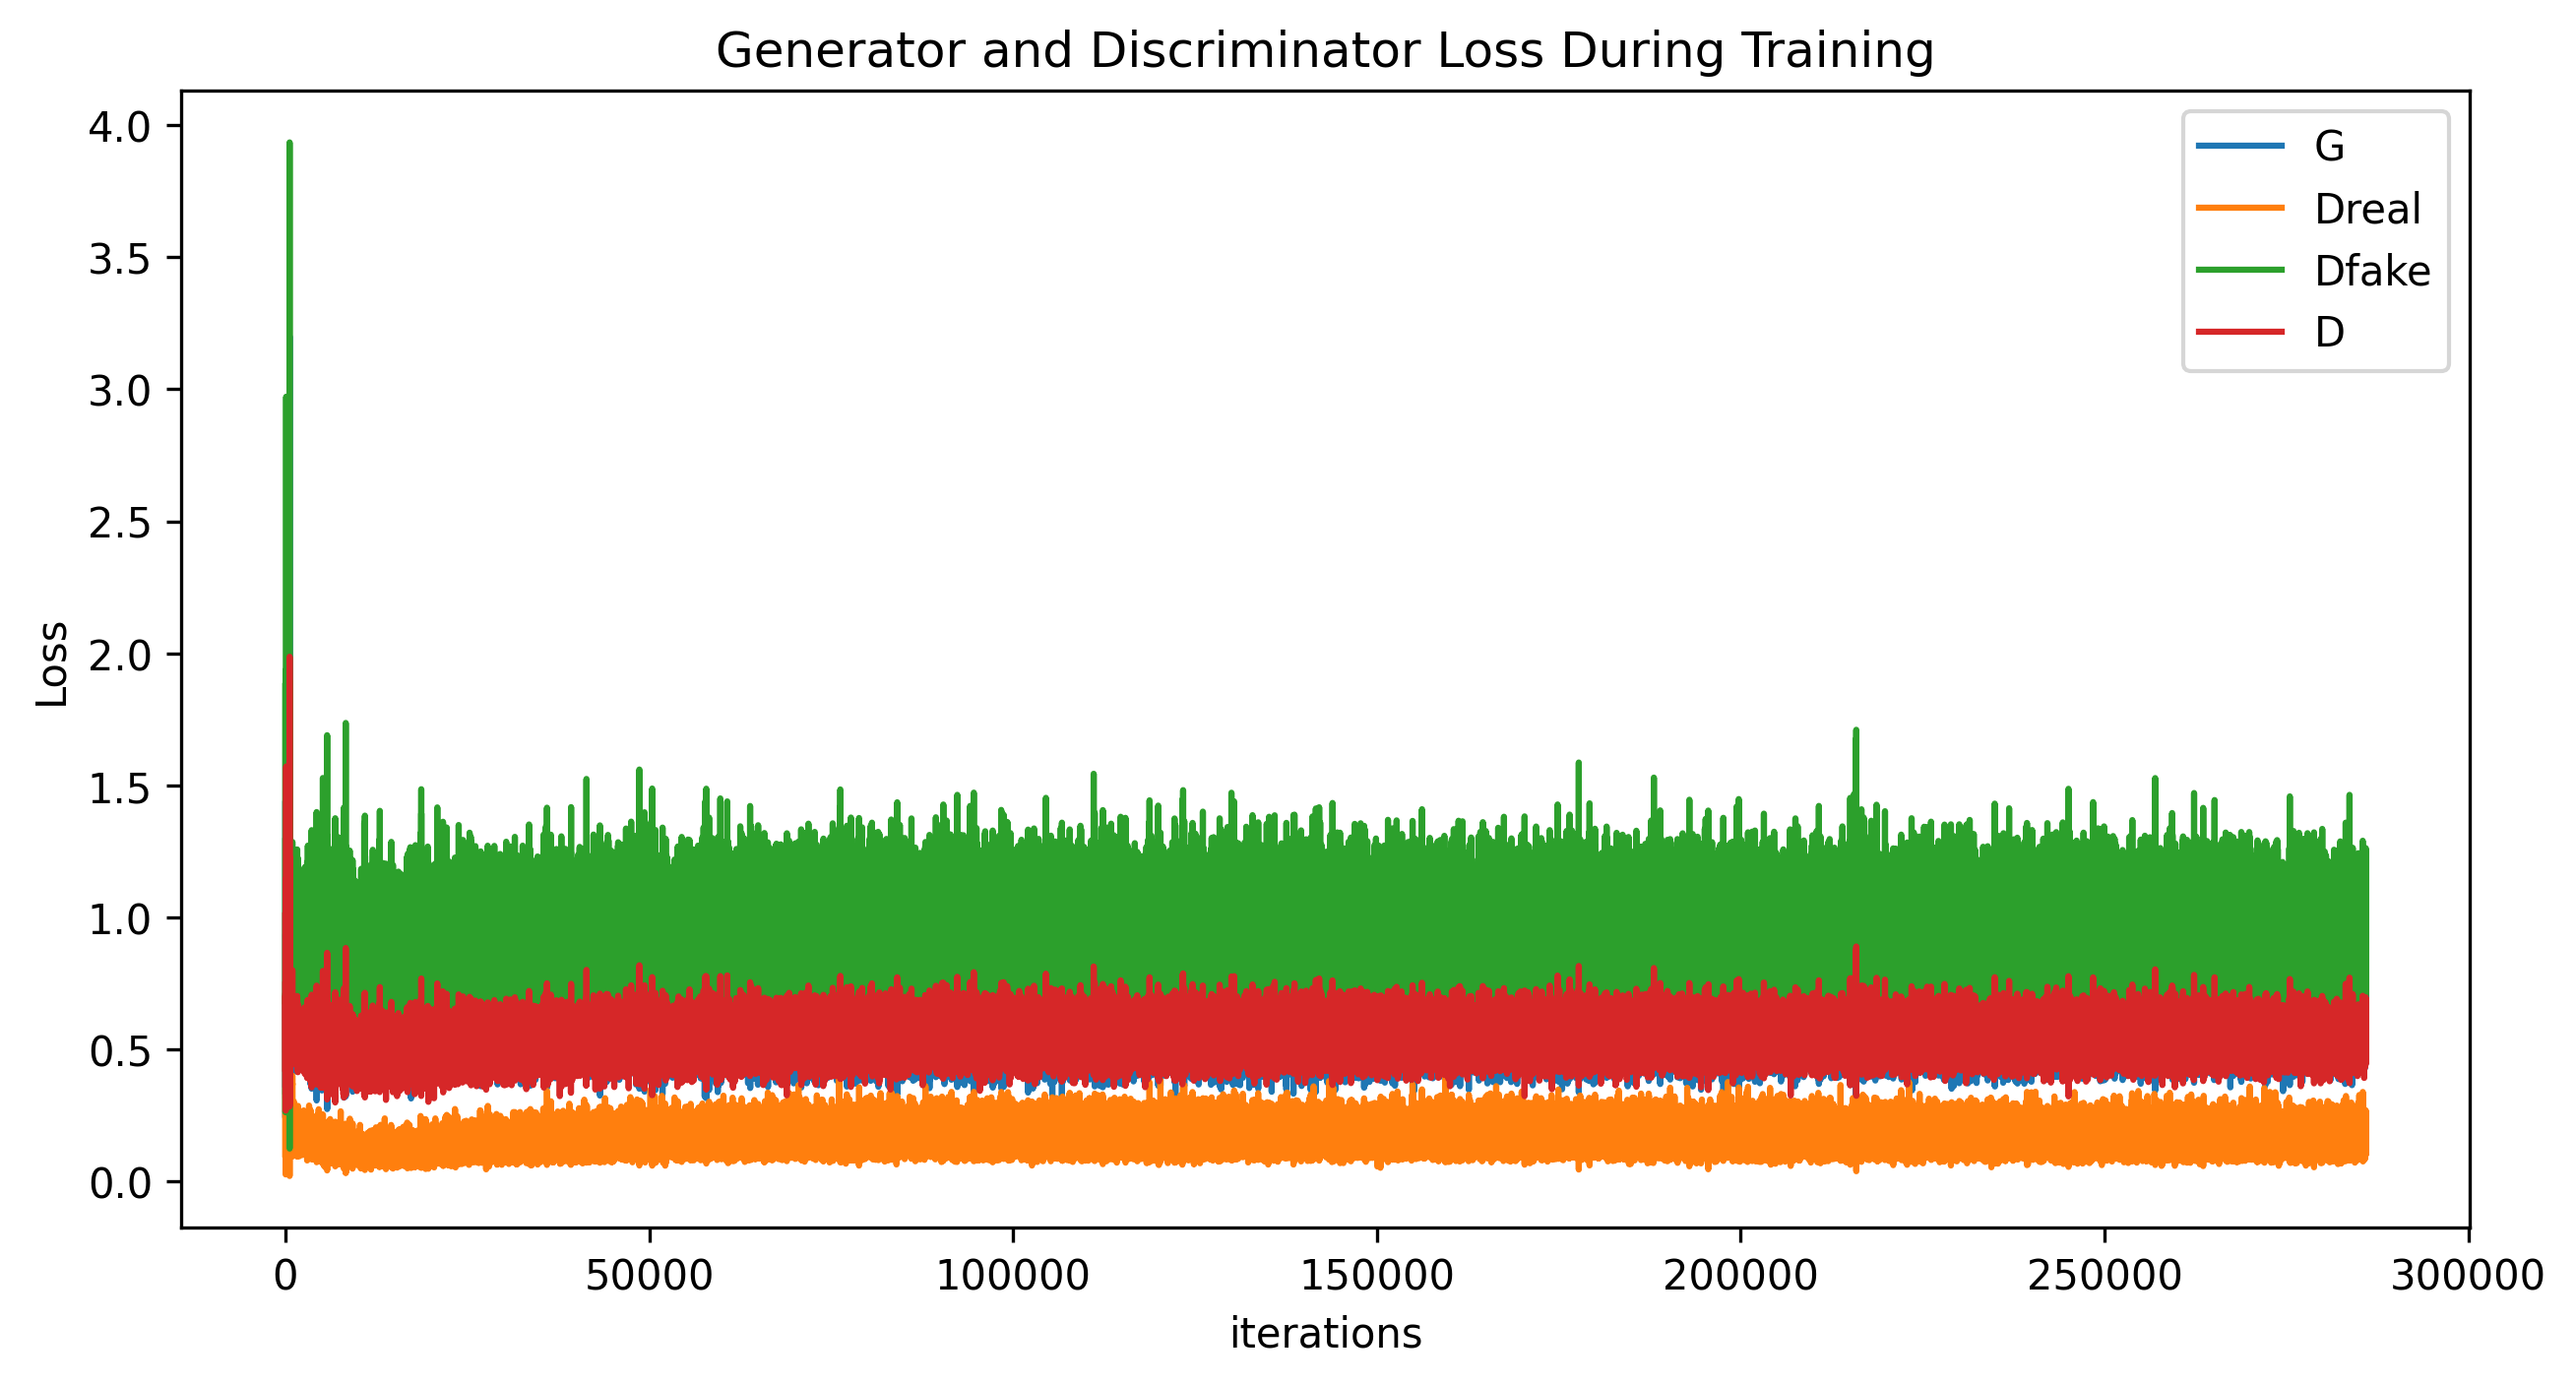

In [23]:
plt.figure(figsize=(10,5),dpi=300)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_real_loss,label="Dreal")
plt.plot(D_fake_loss,label="Dfake")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

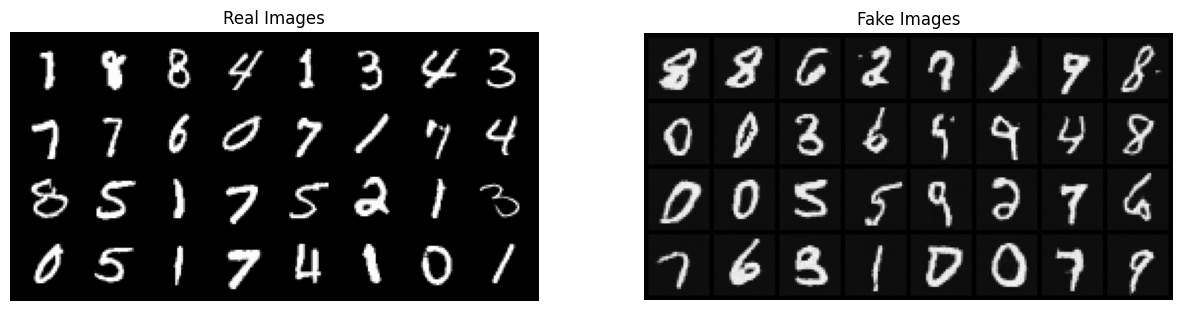

In [24]:
# 繪製原始圖像與生成圖像
real_batch = next(iter(dataloader))

# 原始圖像中抽取一個batch
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=5, normalize=True).cpu(),(1,2,0)))

# 繪製保存的最後一組生成圖像
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1].reshape(-1,1,28,28)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### 再訓練50個Epochs(總共訓練200個Epochs)

In [25]:
for epoch in range(num_epochs):
    for batch_idx, (x,y) in enumerate(dataloader):

        x = x.to(device)
        batch_size = x.shape[0]
        y = y.to(device)
        
        ############################
        # (1) 判別器的反向傳播：最小化 -[logD(x) + log(1 - D(G(z)))]
        ############################

        # -logdx
        disc_output_real = disc(y, x).view(-1)
        loss_real = criterion(disc_output_real,torch.ones_like(disc_output_real))
        loss_real.backward()
        D_x = disc_output_real.mean().item()

        # -log(1-dgz)
        noise = torch.randn((batch_size,z_dim)).to(device)
        gen_ouput_fakedata = gen(y, noise)
        disc_output_fake = disc(y.detach(), gen_ouput_fakedata.detach())
        loss_fake = criterion(disc_output_fake,torch.zeros_like(disc_output_fake))
        loss_fake.backward()
        D_G_z1 = disc_output_fake.mean().item()

        # 計算errorD
        errorD = (loss_real + loss_fake)/2
        optim_disc.step()
        disc.zero_grad()
    
        ############################
        # (2) 生成器的反向傳播：最小化 -log(D(G(z)))
        ############################
        # 生成需要輸入criterion的真實標籤1與預測概率disc_output_fake
        # 注意，由於在此時判別器上的權重已經被更新過了，所以disc_output_fake的值會變化，需要重新生成
        disc_output_fake2 = disc(y, gen_ouput_fakedata)
        # 計算errorG
        errorG = criterion(disc_output_fake2,torch.ones_like(disc_output_fake2))
        errorG.backward() # 反向傳播
        optim_gen.step() # 更新生成器上的權重
        gen.zero_grad() # 清零生成器更新後梯度
        D_G_z2 = disc_output_fake2.mean().item()
        
        # 監控訓練進度
        if batch_idx % 500 == 0 or batch_idx == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' %
                  (epoch+1, num_epochs, batch_idx, len(dataloader),errorD.item(), errorG.item(), D_x, D_G_z1, D_G_z2))

        # 保存errorG和errorD，以便後續繪圖用
        G_losses.append(errorG.item())
        D_real_loss.append(loss_real.item())
        D_fake_loss.append(loss_fake.item())
        D_losses.append(errorD.item())

        # 將固定噪音fixed_noise輸入生成器，查看輸出的結果變化
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(y, fixed_noise).cpu().detach()
            print("fake data saved")
            img_list.append(fake.view(-1,1,28,28))
            
        iters += 1
            
    del x, y, loss_real, loss_fake, errorD, errorG
    gc.collect()
    torch.cuda.empty_cache()


[1/50][0/1875]	Loss_D: 0.5649	Loss_G: 0.5644	D(x): 0.8855	D(G(z)): 0.6102 / 0.5760
fake data saved
[1/50][500/1875]	Loss_D: 0.4694	Loss_G: 0.5602	D(x): 0.7844	D(G(z)): 0.4883 / 0.5792
fake data saved
[1/50][1000/1875]	Loss_D: 0.5615	Loss_G: 0.5110	D(x): 0.8781	D(G(z)): 0.5999 / 0.6169
fake data saved
[1/50][1500/1875]	Loss_D: 0.5622	Loss_G: 0.6208	D(x): 0.8597	D(G(z)): 0.6012 / 0.5462
fake data saved
[2/50][0/1875]	Loss_D: 0.5581	Loss_G: 0.5435	D(x): 0.8278	D(G(z)): 0.5756 / 0.5949
fake data saved
[2/50][500/1875]	Loss_D: 0.4690	Loss_G: 0.6381	D(x): 0.8933	D(G(z)): 0.5479 / 0.5379
fake data saved
[2/50][1000/1875]	Loss_D: 0.4972	Loss_G: 0.5561	D(x): 0.8522	D(G(z)): 0.5426 / 0.5851
fake data saved
[2/50][1500/1875]	Loss_D: 0.5455	Loss_G: 0.6500	D(x): 0.8648	D(G(z)): 0.5957 / 0.5320
fake data saved
[3/50][0/1875]	Loss_D: 0.5579	Loss_G: 0.5569	D(x): 0.8859	D(G(z)): 0.5926 / 0.5909
fake data saved
[3/50][500/1875]	Loss_D: 0.5077	Loss_G: 0.6057	D(x): 0.8865	D(G(z)): 0.5672 / 0.5603
fake dat

fake data saved
[21/50][1000/1875]	Loss_D: 0.4988	Loss_G: 0.5769	D(x): 0.8172	D(G(z)): 0.5321 / 0.5685
fake data saved
[21/50][1500/1875]	Loss_D: 0.5616	Loss_G: 0.5944	D(x): 0.8888	D(G(z)): 0.6117 / 0.5653
fake data saved
[22/50][0/1875]	Loss_D: 0.4895	Loss_G: 0.7199	D(x): 0.8588	D(G(z)): 0.5484 / 0.5004
fake data saved
[22/50][500/1875]	Loss_D: 0.5685	Loss_G: 0.5826	D(x): 0.8799	D(G(z)): 0.6050 / 0.5751
fake data saved
[22/50][1000/1875]	Loss_D: 0.4819	Loss_G: 0.5726	D(x): 0.8329	D(G(z)): 0.5163 / 0.5719
fake data saved
[22/50][1500/1875]	Loss_D: 0.5214	Loss_G: 0.6303	D(x): 0.8440	D(G(z)): 0.5556 / 0.5420
fake data saved
[23/50][0/1875]	Loss_D: 0.4960	Loss_G: 0.7068	D(x): 0.8684	D(G(z)): 0.5573 / 0.5050
fake data saved
[23/50][500/1875]	Loss_D: 0.5603	Loss_G: 0.5762	D(x): 0.8491	D(G(z)): 0.5931 / 0.5735
fake data saved
[23/50][1000/1875]	Loss_D: 0.6053	Loss_G: 0.5324	D(x): 0.8756	D(G(z)): 0.6433 / 0.5959
fake data saved
[23/50][1500/1875]	Loss_D: 0.4852	Loss_G: 0.7574	D(x): 0.8775	D(G

[41/50][1500/1875]	Loss_D: 0.5564	Loss_G: 0.6502	D(x): 0.8935	D(G(z)): 0.6161 / 0.5345
fake data saved
[42/50][0/1875]	Loss_D: 0.4715	Loss_G: 0.5710	D(x): 0.8372	D(G(z)): 0.5048 / 0.5786
fake data saved
[42/50][500/1875]	Loss_D: 0.4990	Loss_G: 0.6194	D(x): 0.8690	D(G(z)): 0.5523 / 0.5549
fake data saved
[42/50][1000/1875]	Loss_D: 0.5066	Loss_G: 0.7665	D(x): 0.8863	D(G(z)): 0.5687 / 0.4801
fake data saved
[42/50][1500/1875]	Loss_D: 0.4991	Loss_G: 0.6474	D(x): 0.8879	D(G(z)): 0.5694 / 0.5307
fake data saved
[43/50][0/1875]	Loss_D: 0.5101	Loss_G: 0.5236	D(x): 0.8811	D(G(z)): 0.5787 / 0.6001
fake data saved
[43/50][500/1875]	Loss_D: 0.4424	Loss_G: 0.5504	D(x): 0.8683	D(G(z)): 0.5099 / 0.5852
fake data saved
[43/50][1000/1875]	Loss_D: 0.4850	Loss_G: 0.6195	D(x): 0.8889	D(G(z)): 0.5542 / 0.5524
fake data saved
[43/50][1500/1875]	Loss_D: 0.5230	Loss_G: 0.5406	D(x): 0.8739	D(G(z)): 0.5761 / 0.5968
fake data saved
[44/50][0/1875]	Loss_D: 0.5808	Loss_G: 0.5906	D(x): 0.9029	D(G(z)): 0.6379 / 0.56

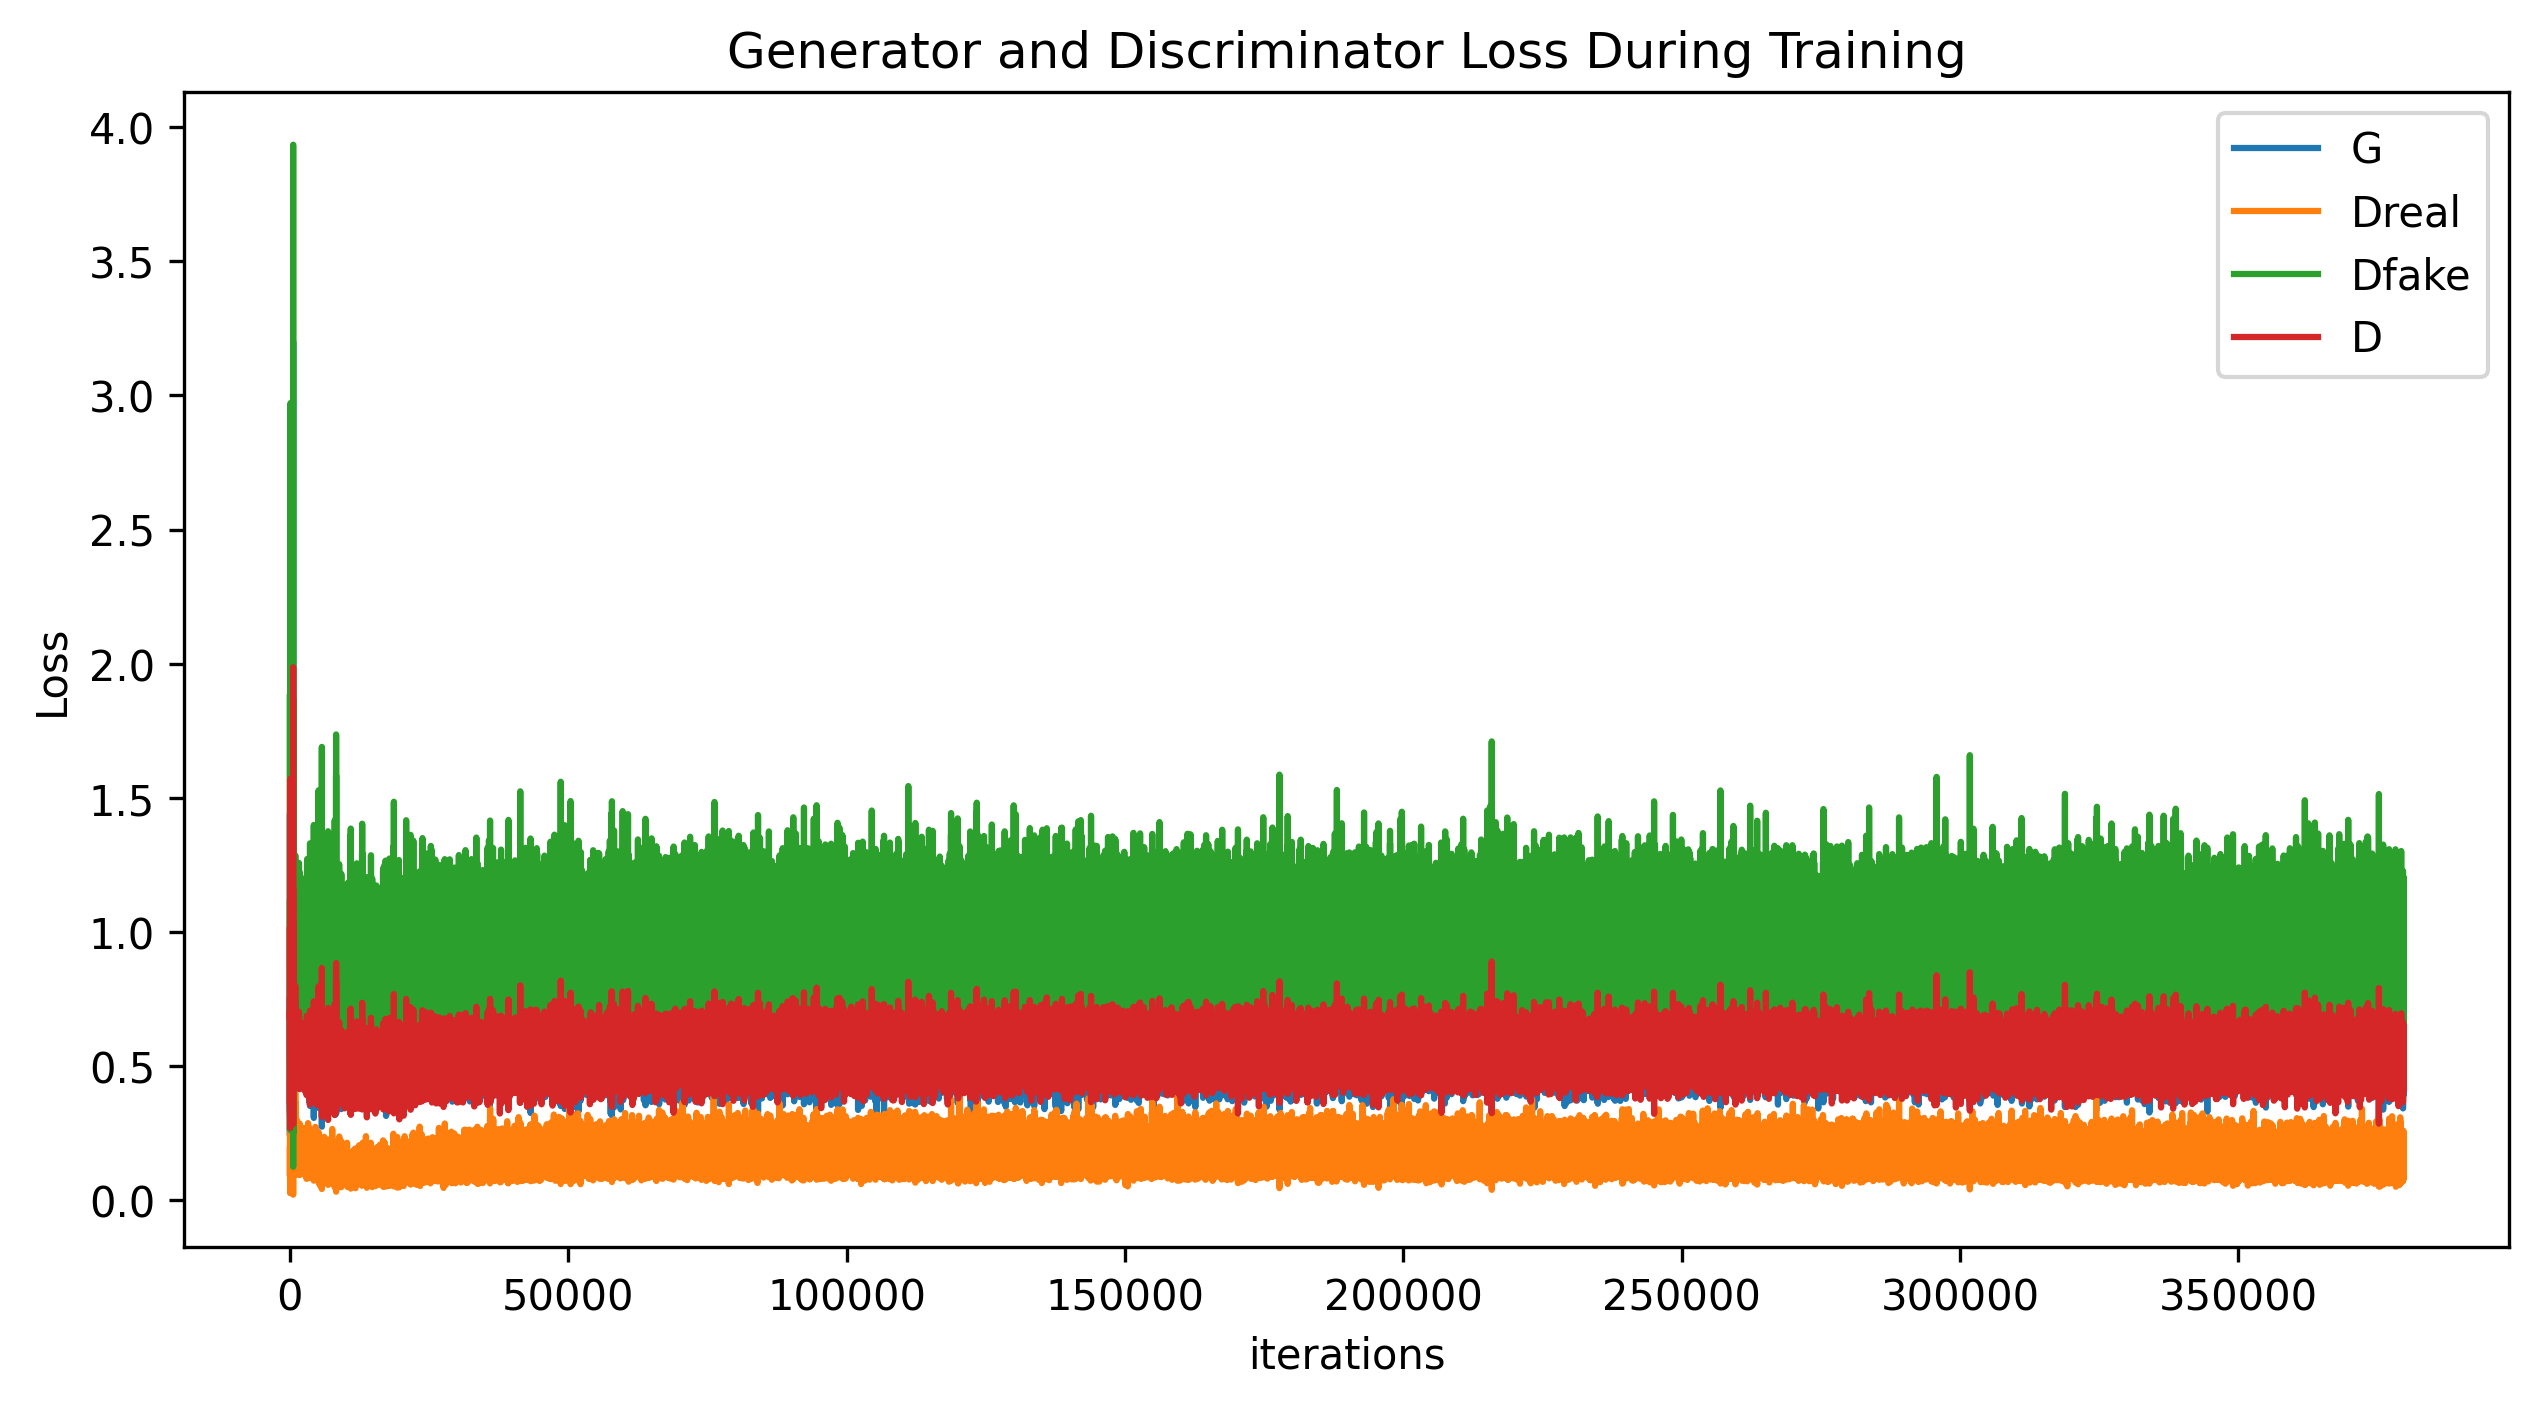

In [26]:
plt.figure(figsize=(10,5),dpi=300)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_real_loss,label="Dreal")
plt.plot(D_fake_loss,label="Dfake")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

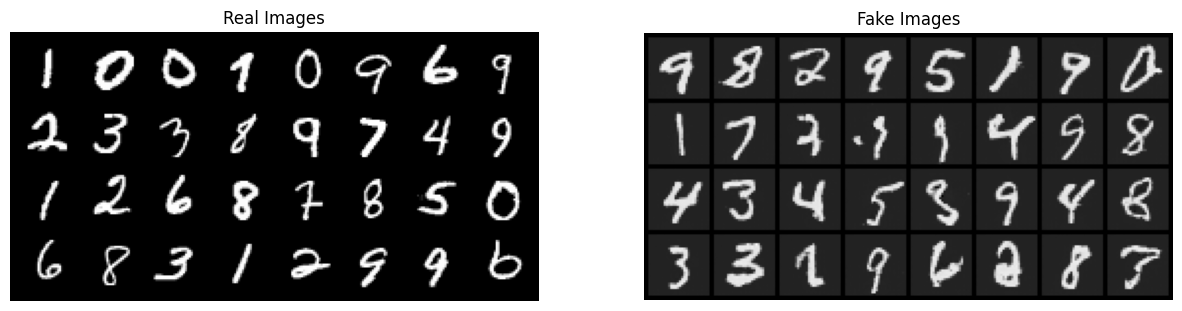

In [28]:
# 繪製原始圖像與生成圖像
real_batch = next(iter(dataloader))

# 原始圖像中抽取一個batch
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=5, normalize=True).cpu(),(1,2,0)))

# 繪製保存的最後一組生成圖像
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1].reshape(-1,1,28,28)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()